<a href="https://colab.research.google.com/github/Harishpatil0172/M5-Forecasting-Kaggle/blob/main/02_M5_Forecasting_kaggle_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement :

1. Can you estimate, as precisely as possible, the point forecasts of the unit sales of various products sold in the USA by Walmart for the next 28 days?

2. How much camping gear will one store sell each month in a year?

# Overview:

The data, covers stores in three US States (**California**, **Texas**, and **Wisconsin**) and includes item level, department, product categories, and store details.

In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

The sales information reaches back from Jan 2011 to June 2016

The data comprises 3049 individual products from 3 categories (Foods, Hobbies, and Household) and 7 departments, sold in 10 stores (4 in CA and 3 each in TX and WI) in 3 states


### Import All Libraries:

In [2]:
#Importing all Necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pyarrow.feather as feather
import matplotlib.pyplot as plt
from datetime import datetime
import plotly.express as px
from shapely.geometry import Point,Polygon
import gc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from shapely import wkt
import warnings
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## All Datasets:

In [4]:
calendar = feather.read_feather('/content/drive/MyDrive/m5-forecasting/calendar.feather')
sales_train_validation = feather.read_feather('/content/drive/MyDrive/m5-forecasting/sales_train_validation.feather')
sample_submission = feather.read_feather('/content/drive/MyDrive/m5-forecasting/sample_submission.feather')
sell_prices = feather.read_feather('/content/drive/MyDrive/m5-forecasting/sell_prices.feather')
sales_train_evaluation = feather.read_feather('/content/drive/MyDrive/m5-forecasting/sales_train_evaluation.feather')

# Data Understanding:

### File 1: “calendar.csv”
Contains information about the dates the products are sold.

* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of
CA,TX or WI allow SNAP2 purchases on the examined date. 1 indicates that SNAP purchases
are allowed.

### File 2: “sell_prices.csv”
Contains information about the price of the products sold per store and date.

* store_id: The id of the store where the product is sold.
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week
(average across seven days). If not available, this means that the product was not sold during the
examined week. Note that although prices are constant at weekly basis, they may change through
time (both training and test set).

### File 3: “sales_train.csv”

Contains the historical daily unit sales data per product and store.

* item_id: The id of the product.
* dept_id: The id of the department the product belongs to.
* cat_id: The id of the category the product belongs to.
* store_id: The id of the store where the product is sold.
* state_id: The State where the store is located.
* d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29.

In [5]:
calendar.head(2)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0


In [6]:
sell_prices.head(2)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [7]:
sales_train_validation.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
sales_train_evaluation.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


# Data Cleaning:

In [9]:
# Calendar data type cast -> Memory Usage Reduction
calendar[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]] = calendar[["month", "snap_CA", "snap_TX", "snap_WI", "wday"]].astype("int8")
calendar[["wm_yr_wk", "year"]] = calendar[["wm_yr_wk", "year"]].astype("int16") 
calendar["date"] = calendar["date"].astype("datetime64")

In [10]:
nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
  calendar[feature].fillna('unknown', inplace = True)

In [11]:
calendar[["weekday", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = calendar[["weekday", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] .astype("category")

In [12]:
# Sales Training dataset cast -> Memory Usage Reduction
sales_train_validation.loc[:, "d_1":] = sales_train_validation.loc[:, "d_1":].astype("int16")

# Int8 = -128 to 127
# Int16 = -32768 to 32767

In [13]:
# Make ID column to sell_price dataframe
sell_prices.loc[:, "id"] = sell_prices.loc[:, "item_id"] + "_" + sell_prices.loc[:, "store_id"] + "_validation"

In [14]:
sell_prices = pd.concat([sell_prices,sell_prices['item_id'].str.split("_",expand=True)],axis = 1)
sell_prices = sell_prices.rename(columns={0:"cat_id", 1:"dept_id"})
sell_prices[["store_id", "item_id", "cat_id", "dept_id"]] = sell_prices[["store_id","item_id", "cat_id", "dept_id"]].astype("category")
sell_prices= sell_prices.drop(columns=2)

### Combine all three dataframe.

1.   Sells_prices 
2.   Calendar
3.   Sells train Validation



In [15]:
df_wide_train = sales_train_validation.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T # .T => Transpose
df_wide_train.index = calendar["date"][:1913]
df_wide_train.columns = sales_train_validation["id"]

In [16]:
df_wide_train.head(3)

id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,5,1,0,2,2,0,0,0,0


In [17]:
def make_dataframe():
    # dataset 
    df_wide_train = sales_train_validation.drop(columns=["item_id", "dept_id", "cat_id", "state_id","store_id", "id"]).T # .T => Transpose
    df_wide_train.index = calendar["date"][:1913]
    df_wide_train.columns = sales_train_validation["id"]
    print("df_wide_train")
    print(df_wide_train.head(3))

    # Making test label dataset
    df_wide_test = pd.DataFrame(np.zeros(shape=(56, len(df_wide_train.columns))), index=calendar.date[1913:], columns=df_wide_train.columns)
    df_wide = pd.concat([df_wide_train, df_wide_test])
    print("df_wide")
    print(df_wide.head(3))


    # Convert wide format to long format
    df_long = df_wide.stack().reset_index(1)
    df_long.columns = ["id", "value"]

    #_____
    print('df_long')
    print(df_long.head(3))
    #_____

    del df_wide_train, df_wide_test, df_wide
    gc.collect() # Garbage Collection
    
    df = pd.merge(pd.merge(df_long.reset_index(), calendar, on="date"), sell_prices, on=["id", "wm_yr_wk"])
    df = df.drop(columns=["d"])
    print("df")
    print(df.head(3))
    
    #df[["cat_id", "store_id", "item_id", "id", "dept_id"]] = df[["cat_id"", store_id", "item_id", "id", "dept_id"]].astype("category")
    df["sell_price"] = df["sell_price"].astype("float16")   
    df["value"] = df["value"].astype("int32")
    df["state_id"] = df["store_id"].str[:2].astype("category")
    print("df")
    print(df.head(3))

    del df_long
    gc.collect()

    return df

df = make_dataframe()

df_wide_train
id          HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   

id          HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   

id          HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0

In [26]:
def add_date_feature(df):
  df["year"] = df["date"].dt.year.astype("int16")
  df["month"] = df["date"].dt.month.astype("int8")
  df["week"] = df["date"].dt.week.astype("int8")
  df["day"] = df["date"].dt.day.astype("int8")
  df["quarter"]  = df["date"].dt.quarter.astype("int8")
  return df

In [28]:
df = add_date_feature(df)
df.head(3)

,date,id,value,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,...,snap_WI,store_id,item_id,sell_price,cat_id,dept_id,state_id,week,day,quarter
0,2011-01-29,HOBBIES_1_008_CA_1_validation,12,11101,Saturday,1,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,29,1
1,2011-01-30,HOBBIES_1_008_CA_1_validation,15,11101,Sunday,2,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,4,30,1
2,2011-01-31,HOBBIES_1_008_CA_1_validation,0,11101,Monday,3,1,2011,unknown,unknown,...,0,CA_1,HOBBIES_1_008,0.459961,HOBBIES,1,CA,5,31,1


# Data Visualization

In [30]:
temp_series = df.groupby(["cat_id", "date"])["value"].sum()
temp_series

cat_id     date      
FOODS      2011-01-29    23178
           2011-01-30    22758
           2011-01-31    17174
           2011-02-01    18878
           2011-02-02    14603
                         ...  
HOUSEHOLD  2016-06-15        0
           2016-06-16        0
           2016-06-17        0
           2016-06-18        0
           2016-06-19        0
Name: value, Length: 5907, dtype: int32

####1.Items sold for each Category

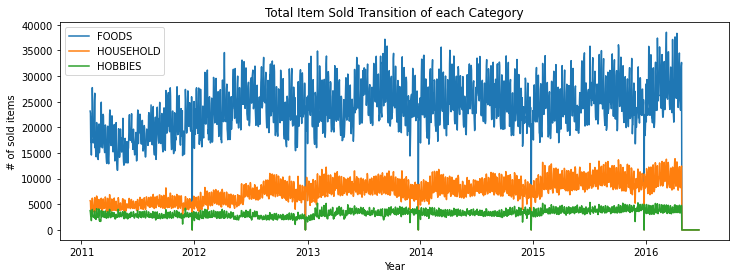

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category")
plt.legend()

* FOODS is the most sold item category of these three categories.
* HOUSEHOLD is the 2nd one, and HOBBIES are the least sold one.
* FOODS category appearently has some periodical feature.
* During one year, it seems more items are sold in summer than in winter.

* HOUSEHOLD category items sold is gradually increasing from 2011.
* However, some items are not in the store in 2011.
So we have to take the total item in the store into account. Periodical Features are not so clear in this category compared to FOODS.

* In HOBBIES category, periodical features are less appearent like HOUSEHOLD category.

* In some point (around the end of year), all categories don't have any sold. So I think we have to consider whether we take these days into account when training models.

####2.Items sold for each Category (2015 only)

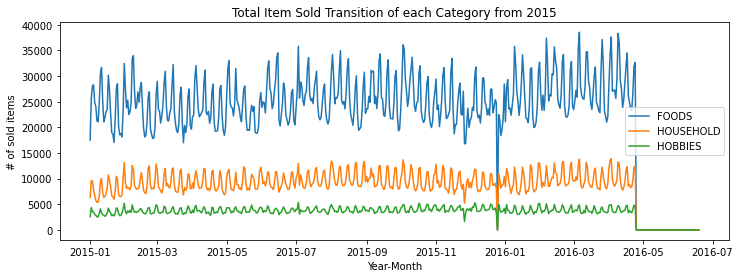

In [32]:
temp_series = temp_series.loc[temp_series.index.get_level_values("date") >= "2015-01-01"]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year-Month")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Category from 2015")
plt.legend()

1. In all categories, the periodical trends is seemed weekly.

2. The day when all item sold is 0 is seemed to be Christmas Day.

####3.Items sold for each Category (December only)

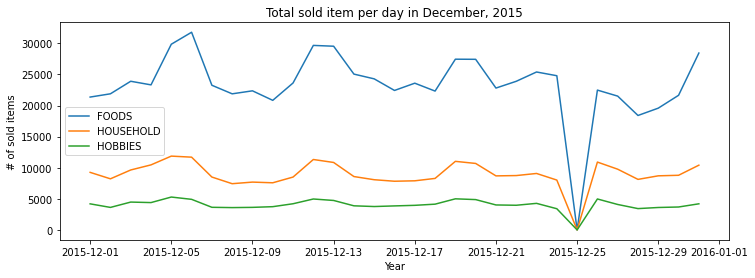

In [33]:
# Plot only December, 2015
temp_series = temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-01") & (temp_series.index.get_level_values("date") <= "2015-12-31")]
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, label="FOODS")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, label="HOUSEHOLD")
plt.plot(temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, label="HOBBIES")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total sold item per day in December, 2015")
plt.legend()

* On Christmas Day, the items sold are seemed to be 0.

In [34]:
temp_series.loc[(temp_series.index.get_level_values("date") >= "2015-12-24") & (temp_series.index.get_level_values("date") <= "2015-12-26")]

cat_id     date      
FOODS      2015-12-24    24801
           2015-12-25       13
           2015-12-26    22488
HOBBIES    2015-12-24     3408
           2015-12-25        0
           2015-12-26     4977
HOUSEHOLD  2015-12-24     8018
           2015-12-25        1
           2015-12-26    10912
Name: value, dtype: int32

* on 2015-12-25 its Christmas.

####4.Which day of the week is the items sold most?

In [35]:
# Item Sold in each day

temp_series = df.groupby(["cat_id", "wday"])["value"].sum()
temp_series

cat_id     wday
FOODS      1       7693153
           2       7767048
           3       6206765
           4       5736838
           5       5651175
           6       5683848
           7       6351112
HOBBIES    1       1076911
           2        976586
           3        813632
           4        777821
           5        786310
           6        786135
           7        907405
HOUSEHOLD  1       2613785
           2       2525992
           3       1948463
           4       1776018
           5       1755251
           6       1775984
           7       2085177
Name: value, dtype: int32

Text(0.5, 1.0, 'Total sold item in each daytype')

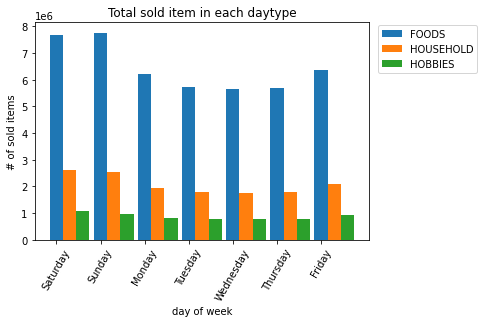

In [43]:
plt.figure(figsize=(6, 4))
left = np.arange(1,8) 
width = 0.3
weeklabel = ["Saturday", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]    


plt.bar(left, temp_series[temp_series.index.get_level_values("cat_id") == "FOODS"].values, width=width, label="FOODS")
plt.bar(left + width, temp_series[temp_series.index.get_level_values("cat_id") == "HOUSEHOLD"].values, width=width, label="HOUSEHOLD")
plt.bar(left + width + width, temp_series[temp_series.index.get_level_values("cat_id") == "HOBBIES"].values, width=width, label="HOBBIES")
plt.legend(bbox_to_anchor=(1.01, 1.01))
plt.xticks(left, weeklabel, rotation=60)
plt.xlabel("day of week")
plt.ylabel("# of sold items")
plt.title("Total sold item in each daytype")

* Saturday or Sunday is the day which the items are most sold.
* Tuesday or Wednesday is the least sold days.

####5.Item sold in each State and Store

In [44]:
temp_series = df.groupby(["state_id", "date"])["value"].sum()
temp_series

state_id  date      
CA        2011-01-29    14195
          2011-01-30    13805
          2011-01-31    10108
          2011-02-01    11047
          2011-02-02     9925
                        ...  
WI        2016-06-15        0
          2016-06-16        0
          2016-06-17        0
          2016-06-18        0
          2016-06-19        0
Name: value, Length: 5907, dtype: int32

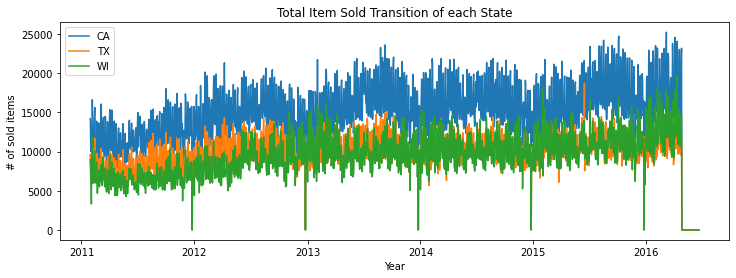

In [45]:
plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "CA"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "CA"].values, label="CA")
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "TX"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "TX"].values, label="TX")
plt.plot(temp_series[temp_series.index.get_level_values("state_id") == "WI"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("state_id") == "WI"].values, label="WI")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each State")
plt.legend()

* CA is the most sold state of these three states.
* TX and WI are not so different except for the year 2011 and 2012.



Let's focus on stores in CA.

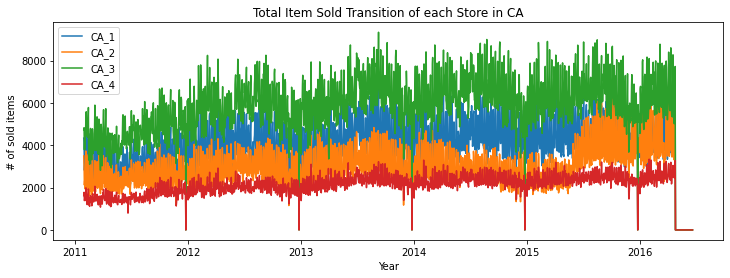

In [46]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].values, label="CA_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].values, label="CA_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].values, label="CA_3")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].values, label="CA_4")

plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total Item Sold Transition of each Store in CA")
plt.legend()

* Three stores in CA have similar amount of item sold record.
* CA_3 has more item sold a little bit compared to others.
* From around 2015 Summer, CA_2 increased its sold record rapidly. We have to investigate the reasons.

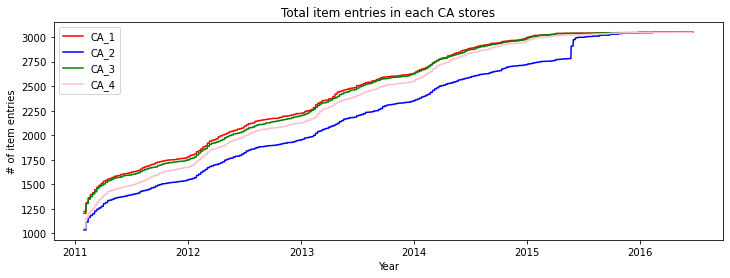

In [50]:
temp_series = df.groupby(["store_id", "date"])["item_id"].count()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_1"].values, label="CA_1",color = "red")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_2"].values, label="CA_2", color = "blue")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_3"].values, label="CA_3",color = "green")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "CA_4"].values, label="CA_4",color = "pink")


plt.xlabel("Year")
plt.ylabel("# of item entries")
plt.title("Total item entries in each CA stores")
plt.legend()

* From around 2015 Summer, CA_2 increased its sold record rapidly. We have to investigate the reasons.

* It is because item registered in CA_2 increased rapidly.
* After summer in 2015, all stores in CA have similar registered item count

#### 6.Standard deviation analysis in each store¶

* Now let's check each store's standard deviation.
* In the previous section, we found that CA_3 has a little bit more sales than other stores in CA.
* How about deviation of these stores?

In [51]:
temp_series = df.groupby(["state_id", "store_id", "year", "month"])["value"].std()
temp_series

state_id  store_id  year  month
CA        CA_1      2011  1        8.168679
                          2        6.153654
                          3        5.044606
                          4        4.943261
                          5        4.555540
                                     ...   
WI        WI_3      2016  8             NaN
                          9             NaN
                          10            NaN
                          11            NaN
                          12            NaN
Name: value, Length: 2160, dtype: float64

Text(0.5, 0.98, 'Standard deviation of sold items in one month in each store')

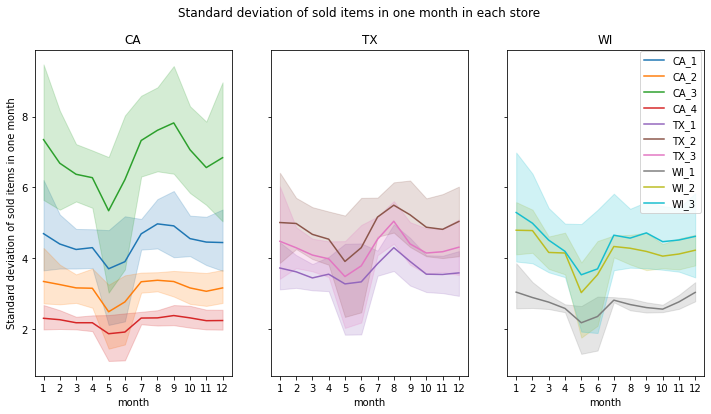

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)

# We can use for loop 
sns.lineplot(x=temp_series[(temp_series.index.get_level_values("state_id") == "CA")].index.get_level_values("month"), 
             y=temp_series[(temp_series.index.get_level_values("state_id") == "CA")].values, 
             hue=temp_series[(temp_series.index.get_level_values("state_id") == "CA")].index.get_level_values("store_id"), 
             legend=False,
             ax=axs[0])
sns.lineplot(x=temp_series[temp_series.index.get_level_values("state_id") == "TX"].index.get_level_values("month"),
             y=temp_series[temp_series.index.get_level_values("state_id") == "TX"].values, 
             hue=temp_series[temp_series.index.get_level_values("state_id") == "TX"].index.get_level_values("store_id"), 
             legend=False,
             ax=axs[1])
sns.lineplot(x=temp_series[temp_series.index.get_level_values("state_id") == "WI"].index.get_level_values("month"),
             y=temp_series[temp_series.index.get_level_values("state_id") == "WI"].values, 
             hue=temp_series[temp_series.index.get_level_values("state_id") == "WI"].index.get_level_values("store_id"),
             ax=axs[2])



plt.legend(bbox_to_anchor=(1.01, 1.01))
axs[0].set_title("CA")
axs[0].set_xticks(range(1, 13))
axs[0].set_ylabel("Standard deviation of sold items in one month")
axs[1].set_title("TX")
axs[1].set_xticks(range(1, 13))
axs[2].set_title("WI")
axs[2].set_xticks(range(1, 13))

fig.suptitle("Standard deviation of sold items in one month in each store")

* With lineplot method in seaborn, we can plot single line with error bands showing a confidence interval.
You can serach seaborn lineplot and find this sentence. (https://seaborn.pydata.org/generated/seaborn.lineplot.html)

* By default, the plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.

* In this case, this command plots each month item sold standard deviation with confidence interval in 4 years. (From 2011 to 2015)

* Since CA_3 is the most sold store in CA, standard deviation of this store is also higher than others.


Let's check other state, WI next!

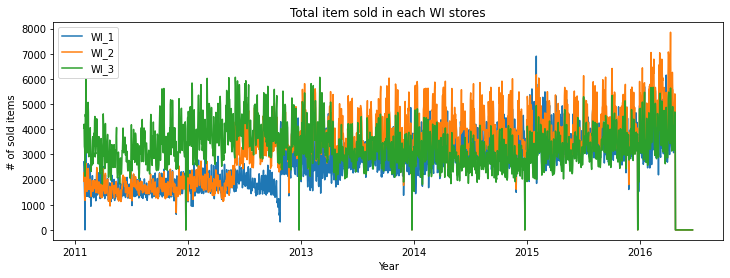

In [53]:
temp_series = df.groupby(["store_id", "date"])["value"].sum()

plt.figure(figsize=(12, 4))
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_1"].values, label="WI_1")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_2"].values, label="WI_2")
plt.plot(temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].index.get_level_values("date"), temp_series[temp_series.index.get_level_values("store_id") == "WI_3"].values, label="WI_3")
plt.xlabel("Year")
plt.ylabel("# of sold items")
plt.title("Total item sold in each WI stores")
plt.legend()

# reference

https://www.kaggle.com/code/ryuheeeei/let-s-start-from-here-beginners-data-analysis

In [18]:
# df1 = pd.DataFrame(calendar)
# df2 = pd.DataFrame(sell_prices)

# # Finding Common columns

# print(np.intersect1d(df2.columns, df1.columns))

In [19]:
# # inner join
# cal_sell = pd.merge(calendar, sell_prices, on='wm_yr_wk', how='inner')

In [20]:
# cal_sell.head(2)

In [21]:
# import plotly.express as px


# fig = px.line(cal_sell, x="date", y="sell_price", title='Life expectancy in Canada')
# fig.show()

In [22]:
# calendar.head(2)

In [23]:
# conda create -n mitoenv python=3.8
# # conda activate mitoenv
# ! pip install mitoinstaller
#! pip install mitosheet
# python -m mitoinstaller install

In [24]:
# import mitosheet

In [25]:
# for i, var in enumerate(["year", "weekday", "month", "event_name_1", "event_name_2", 
#                          "event_type_1", "event_type_2", "snap_CA", "snap_TX", "snap_WI"]):
#     plt.figure()
#     g = sns.countplot(calendar[var])
#     g.set_xticklabels(g.get_xticklabels(), rotation=45)
#     g.set_title(var)